# Crossmatching NASA Exoplanet Archive data with Gaia DR3 using Gaia DR2 IDs

The Nasa Exoplanet Archive (NEA; https://exoplanetarchive.ipac.caltech.edu/) contains the most up to date information on exoplanet properties. We wish to crossmatch data in the NEA with the most recent data in the Gaia archive (https://gea.esac.esa.int/archive/), which as of 4/11/22 is DR3. The NEA contains Gaia IDs for the exoplanet host stars. However, as of 4/11/22, the NEA Gaia IDs are from Gaia DR2. Unfortunately, the Gaia IDs for the same stars are not neccessarily the same between different data releases. Therefore, we need to carefully crossmatch the Gaia DR2 IDs in the NEA with the correct Gaia DR3 stars.

The https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_auxiliary_tables/ssec_dm_dr2_neighbourhood.html

# Setup 

## Importing modules

In [1]:
import pandas as pd
import re
from astroquery.gaia import Gaia

## Downloading and reading in NEA data

We use the most up to date data from the NEA compositve planetary data: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PSCompPars. We download all the columns from the most recent data from the NEA compositve planetary catalogue as a csv, which produces a file with a name like, PSCompPars_2022.10.29_03.02.41.csv, where the numbers correspond to the date and time the data were downloaded. Something in the header of the csv file meant pandas could not read the data properly, so the quick work around is to remove all the extraneous header info (all rows starting with #).

In [2]:
# Read in the data using pandas
# exoplanets = pd.read_csv("PSCompPars_2022.10.29_03.02.41.csv", skiprows=315, low_memory=False)  # skipping the first 315 rows which are header information
# exoplanets = pd.read_csv("PSCompPars_2022.10.29_03.02.41.csv", skiprows=315)  # skipping the first 315 rows which are header information
# exoplanets = pd.read_csv("PSCompPars_2022.10.29_03.02.41.csv", skiprows=315)  # skipping the first 315 rows which are header information
# exoplanets = pd.read_csv("PSCompPars_2022.11.04_06.38.57.csv", skiprows=94)
# exoplanets = pd.read_csv("PSCompPars_2022.11.04_06.38.57_nohead.csv")
exoplanets = pd.read_csv("PSCompPars_2022.11.04_06.46.09.csv")

In [3]:
# exoplanets

In [4]:
gaia_id_number = pd.DataFrame(exoplanets['gaia_id'].str.split(expand=True)[2])

In [5]:
gaia_id_number.columns=['gaia_id_number']

In [6]:
gaia_id_number

,gaia_id_number
0,3946945413106333696
1,1696798367260229376
2,1920113512486282240
3,1385293808145621504
4,2135550755683407232
...,...
5192,348020448377061376
5193,348020448377061376
5194,348020448377061376
5195,3794167001116433152


In [7]:
#gaia_id_number.to_csv("PSCompPars_2022.11.04_06.46.09_gaia_id_drop_number_only.csv", index=False)

In [8]:
# Dropping rows with no Gaia ids as this will just complicate the analysis.
gaia_id_number.dropna().to_csv("PSCompPars_2022.11.04_06.46.09_gaia_id_number.csv", index=False)

In [ ]:
# exoplanets['gaia_id'].to_csv("gaia_full_name_test.csv", index=False)

In [35]:
gaia_id_number['gaia_id_number'].nunique()

3703

In [36]:
gaia_id_number['gaia_id_number']

0       3946945413106333696
1       1696798367260229376
2       1920113512486282240
3       1385293808145621504
4       2135550755683407232
               ...         
5192     348020448377061376
5193     348020448377061376
5194     348020448377061376
5195    3794167001116433152
5196    4298361114750843904
Name: gaia_id_number, Length: 5197, dtype: object

# Login to Gaia Archive

In [ ]:
#### We can log onto the Gaia archive using the following formats:
#### Gaia.login_gui() - will display window to provide a username and password
#### Gaia.login() - a prompt will ask the user for name and password
#### Gaia.login(user=[username], password=[password]) - just type the username and password in the given fields
#### Gaia.login(credentials_file=[filename] - A path to the file that contains username and password. The username and password must be in different lines!

In [9]:
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]


User:  slongmor
Password:  ·········


OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


# Upload the Gaia DR2 ids to the Gaia archive

Now we need to upload the csv file we created above with Gaia DR2 ID's from the NASA Exoplanets Archive. This can be done on the Gaia archive website using the GUI. Cannot upload the same table twice unless we change the name as they are unique.

In [11]:
# Gaia.upload_table(upload_resource="PSCompPars_2022.11.04_06.46.09_gaia_id_number_dropna.csv", table_name="PSCompPars_2022.11.04_06.46.09_gaia_id_number_dropna.csv", format="CSV")
# Gaia.upload_table(upload_resource="PSCompPars_2022.11.04_06.46.09_gaia_id_number.csv", table_name="PSCompPars_2022.11.04_06.46.09_gaia_id_number.csv", format="CSV")
Gaia.upload_table(upload_resource="PSCompPars_2022.11.04_06.46.09_gaia_id_number.csv", table_name="gaia_NEA_dr2_IDs", format="CSV")

Sending file: PSCompPars_2022.11.04_06.46.09_gaia_id_number.csv
Uploaded table 'gaia_NEA_dr2_IDs'.


# Submit crossmatch query

We need to provide a gaia table name to query as well as the username that will be used to load the uploaded table.
Set a name for the file to which queried data will be saved.

In [12]:
table = "gaiadr3.dr2_neighbourhood"
username = "slongmor"
filename = "gaiadr3.dr2_neighbourhood.csv"
# mytable = "PSCompPars_2022.11.04_06.46.09_gaia_id_number.csv"
mytable = "gaia_NEA_dr2_IDs"

In [13]:
query = f"""
SELECT dr2_names.*, both_names.*
FROM user_{username}.{mytable} AS dr2_names
JOIN {table} as both_names 
    ON both_names.dr2_source_id = dr2_names.gaia_id_number
WHERE ABS(magnitude_difference) < 0.1
"""

In [14]:
#print(query)

In [15]:
Gaia.launch_job_async(query).get_results().to_pandas().to_csv(f"{filename}", index=False)

INFO: Query finished. [astroquery.utils.tap.core]


# Inspect crossmatch output

In [16]:
crossmatch = pd.read_csv(filename)

In [17]:
crossmatch

,gaia_nea_dr2_ids_oid,gaia_id_number,dr2_source_id,dr3_source_id,angular_distance,magnitude_difference,proper_motion_propagation
0,1,3946945413106333696,3946945413106333696,3946945413106333696,0.171659,0.064815,True
1,2,1696798367260229376,1696798367260229376,1696798367260229376,0.272179,0.056798,True
2,3,1920113512486282240,1920113512486282240,1920113512486282240,0.190454,0.050376,True
3,4,1385293808145621504,1385293808145621504,1385293808145621504,0.085541,0.015930,True
4,5,2135550755683407232,2135550755683407232,2135550755683407232,0.208378,0.016607,True
...,...,...,...,...,...,...,...
4930,4991,348020448377061376,348020448377061376,348020482735930112,0.904173,0.067670,True
4931,4992,348020448377061376,348020448377061376,348020482735930112,0.904173,0.067670,True
4932,4993,348020448377061376,348020448377061376,348020482735930112,0.904173,0.067670,True
4933,4994,3794167001116433152,3794167001116433152,3794167001116704000,0.252776,0.093633,True


<AxesSubplot:>

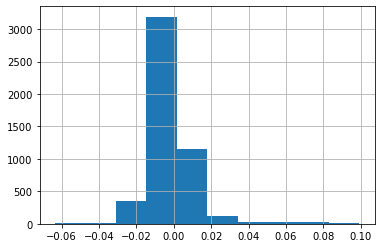

In [20]:
crossmatch['magnitude_difference'].hist()

<AxesSubplot:>

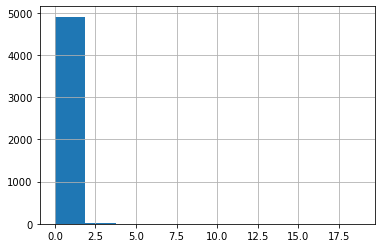

In [21]:
crossmatch['angular_distance'].hist()

In [31]:
crossmatch_unique = crossmatch[['gaia_id_number','dr2_source_id','dr3_source_id','angular_distance','magnitude_difference','proper_motion_propagation']].drop_duplicates()

In [32]:
crossmatch_unique

,gaia_id_number,dr2_source_id,dr3_source_id,angular_distance,magnitude_difference,proper_motion_propagation
0,3946945413106333696,3946945413106333696,3946945413106333696,0.171659,0.064815,True
1,1696798367260229376,1696798367260229376,1696798367260229376,0.272179,0.056798,True
2,1920113512486282240,1920113512486282240,1920113512486282240,0.190454,0.050376,True
3,1385293808145621504,1385293808145621504,1385293808145621504,0.085541,0.015930,True
4,2135550755683407232,2135550755683407232,2135550755683407232,0.208378,0.016607,True
...,...,...,...,...,...,...
4928,1244571953471006720,1244571953471006720,1244571953471006720,0.497859,0.061234,True
4929,886479673643096448,886479673643096448,886479673643853952,1.306490,0.066464,True
4930,348020448377061376,348020448377061376,348020482735930112,0.904173,0.067670,True
4933,3794167001116433152,3794167001116433152,3794167001116704000,0.252776,0.093633,True


In [37]:
crossmatch_unique['dr2_source_id'].nunique()

3656